## ResNet 모델 파이토치 구현
### layer가 깊어짐에 따라 기울기 소실 문제가 생겨 layer가 깊어 질 수록 오차가 더 커짐
### 그에 따라 잔차연결을 활용해 기울기 소실 문제를 해결 - > 자세한 내용은 논문
### 논문 링크: https://arxiv.org/abs/1512.03385

## 데이터셋 다운로드 훈련용 50만장, 검증용 10만장

In [1]:
!pip install natsort opencv-python tqdm


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import cv2
import torchvision.transforms as T
import natsort
from tqdm import tqdm


In [3]:
# 대규모의 데이터로 학습 하고 싶으면 주석해제

# torchvision.datasets.INaturalist(root='./data',version='2021_train_mini', download=True)
# torchvision.datasets.INaturalist(root='./data',version='2021_valid', download=True)

## 데이터의 클래스 수가 10000개여서 300개에 대해서만 학습


In [4]:
class INaturalist_Dataset(Dataset):
    def __init__(self, train='train', transforms=None):
        self.root_path = 'data/2021_train_mini' if train=='train' else 'data/2021_valid'
      
        self.class_names = [class_name for class_name in natsort.natsorted(os.listdir(self.root_path))][:300] 
        self.data_path = []
        for class_idx, class_name in enumerate(self.class_names):
            for file in os.listdir(os.path.join(self.root_path, class_name)):
                self.data_path.append({'file_path':os.path.join(self.root_path, class_name, file), 'class_idx':class_idx})
        self.transforms = transforms
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self, idx):
        file_path = self.data_path[idx]['file_path']
        class_idx =  self.data_path[idx]['class_idx']
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, class_idx

## 데이터증강 

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_transform = T.Compose([
    #T.ToPILImage(),
    T.ToTensor(),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    normalize
])

val_transform = T.Compose([
    #T.ToPILImage(),
    T.ToTensor(),
    T.Resize((224, 224)),
   
    normalize
])

In [6]:
batch_size = 16
# 대규모 데이터 학습 하고 싶으면 해제
# trainset = INaturalist_Dataset('train', train_transform)
# testset = INaturalist_Dataset('val', val_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=0)


# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=0)

In [7]:
trainset = torchvision.datasets.STL10('./data', split='train', download=True, transform=train_transform)
testset = torchvision.datasets.STL10('./data', split='test', download=True, transform=val_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


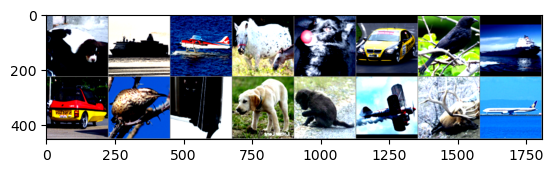

Atypoides_riversi Araneus_bicentenarius Lumbricus_terrestris Aculepeira_ceropegia Atypoides_riversi Serpula_columbiana Sabella_spallanzanii Araneus_bicentenarius Serpula_columbiana Sabella_spallanzanii Spirobranchus_cariniferus Atypoides_riversi Agalenatea_redii Lumbricus_terrestris Eratigena_duellica Lumbricus_terrestris


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
classes = [class_name.split('_')[-2]+'_'+class_name.split('_')[-1] 
           for class_name in natsort.natsorted(os.listdir('data/2021_train_mini'))[:300]]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## ResNet 구현
### ResNet은 layer의 깊에 따라 활용하는 Block들이 다름


In [9]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

## Basic Block

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        r"""
         - inplanes: input channel size
         - planes: output channel size
         - groups, base_width: ResNext나 Wide ResNet의 경우 사용
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        # Basic Block의 구조
        self.conv1 = conv3x3(inplanes, planes, stride)  # conv1에서 downsample
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

## Bottleneck

In [11]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups
        
        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일 
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [13]:
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 10)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 10)
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 10)
resnet101 = ResNet(Bottleneck, [3, 4, 23, 3], 10)
resnet152 = ResNet(Bottleneck, [3, 8, 36, 3], 10)

## 모델 학습

In [14]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(BasicBlock, [2, 2, 2, 2], 10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 30
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [16]:
def train(loader, model,optimizer, criterion):
    running_loss = 0.0
    
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(tqdm(loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
       
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss /len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [17]:
def validation(loader, model, optimizer, criterion):
    running_loss = 0.0
    
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()



            # print statistics
            running_loss += loss.item()
    epoch_loss = running_loss /len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [18]:

for epoch in range(epochs):  # loop over the dataset multiple times
    best_acc = 0

    train_loss, train_acc = train(trainloader,model, optimizer, criterion)
    val_loss, val_acc = validation(testloader,model, optimizer, criterion)
    scheduler.step()
    is_best = val_acc > best_acc
    best_acc1 = max(val_acc, best_acc)
    
    
    save_checkpoint({
            'epoch': epoch + 1,

            'state_dict': model.state_dict(),
            'best_acc1': best_acc,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict()
        }, is_best)
        
    print(f'[{epoch}], train_loss:{train_loss:.4f}, val_loss:{val_loss:.4f}, train_acc:{train_acc*100:.4f}, val_acc:{val_acc*100:.4f}')
       
   
        
       


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.40it/s]


[0], train_loss:2.0641, val_loss:1.6835, train_acc:25.2200, val_acc:33.8875


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.05it/s]


[1], train_loss:1.7361, val_loss:1.5734, train_acc:33.3200, val_acc:37.6250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 82.02it/s]


[2], train_loss:1.5517, val_loss:1.4863, train_acc:41.3600, val_acc:43.6875


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.72it/s]


[3], train_loss:1.4188, val_loss:1.3164, train_acc:46.5600, val_acc:49.2750


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.87it/s]


[4], train_loss:1.2964, val_loss:1.4755, train_acc:51.4200, val_acc:45.4875


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.20it/s]


[5], train_loss:1.1808, val_loss:1.3068, train_acc:56.2600, val_acc:53.4250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 75.91it/s]


[6], train_loss:1.0834, val_loss:1.1930, train_acc:60.6000, val_acc:57.0625


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.18it/s]


[7], train_loss:0.9721, val_loss:1.3802, train_acc:63.5800, val_acc:54.5375


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.08it/s]


[8], train_loss:0.9313, val_loss:1.4103, train_acc:66.1200, val_acc:52.8500


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.30it/s]


[9], train_loss:0.8005, val_loss:1.2225, train_acc:71.8000, val_acc:58.6250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.42it/s]


[10], train_loss:0.5063, val_loss:0.8545, train_acc:82.5800, val_acc:69.9250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 79.92it/s]


[11], train_loss:0.4225, val_loss:0.8759, train_acc:85.6000, val_acc:69.9625


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.36it/s]


[12], train_loss:0.3617, val_loss:0.8738, train_acc:87.7200, val_acc:70.5625


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.34it/s]


[13], train_loss:0.3158, val_loss:0.9129, train_acc:89.6600, val_acc:70.2000


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.69it/s]


[14], train_loss:0.2806, val_loss:0.9051, train_acc:90.9200, val_acc:70.4125


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.95it/s]


[15], train_loss:0.2567, val_loss:0.9481, train_acc:92.0800, val_acc:69.7500


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.17it/s]


[16], train_loss:0.2216, val_loss:0.9451, train_acc:93.2400, val_acc:70.3375


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 79.12it/s]


[17], train_loss:0.1711, val_loss:0.9639, train_acc:95.2600, val_acc:70.2000


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 79.09it/s]


[18], train_loss:0.1558, val_loss:0.9776, train_acc:95.6800, val_acc:70.2250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.76it/s]


[19], train_loss:0.1315, val_loss:1.0157, train_acc:96.7600, val_acc:69.1000


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.22it/s]


[20], train_loss:0.0961, val_loss:0.9901, train_acc:97.8800, val_acc:70.1500


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.09it/s]


[21], train_loss:0.0915, val_loss:0.9889, train_acc:98.0000, val_acc:70.1750


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 79.74it/s]


[22], train_loss:0.0934, val_loss:1.0013, train_acc:98.2600, val_acc:70.0125


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 79.73it/s]


[23], train_loss:0.0880, val_loss:0.9941, train_acc:98.4200, val_acc:70.2000


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.71it/s]


[24], train_loss:0.0846, val_loss:1.0018, train_acc:98.4400, val_acc:70.0250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.04it/s]


[25], train_loss:0.0802, val_loss:0.9926, train_acc:98.6400, val_acc:70.0250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.18it/s]


[26], train_loss:0.0806, val_loss:0.9929, train_acc:98.4800, val_acc:70.2500


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.52it/s]


[27], train_loss:0.0771, val_loss:0.9975, train_acc:98.6200, val_acc:70.5375


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 73.74it/s]


[28], train_loss:0.0743, val_loss:1.0038, train_acc:98.8600, val_acc:70.1250


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.49it/s]


[29], train_loss:0.0793, val_loss:1.0036, train_acc:98.3800, val_acc:70.4875
